## This code is for evaluating the classificators' performance

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
from cycler import cycler

#### Loading in the data
##### example for file name: vgg16_model_orig_split_1_ratio_None_mode-history 

In [4]:
model = []
split = []
ratio = []
mode = []
paths = []
for path, _, fnames in os.walk('./Results'):
    for x in fnames:
        if x.lower().endswith('pkl'):
            pth = os.path.join(path, x)
            x = x.replace('efficientnet_b0', 'efficientnetb0')
            x = x.replace('model', '')
            x = x.replace('split', '')
            x = x.replace('ratio', '')
            x = x.replace('mode', '')
            x = x.replace('__', '_')
            x = x.split('_')
            model.append(x[0])
            split.append(x[1])
            ratio.append(float(x[2]))
            mode.append(x[3])
            paths.append(pth)
datas = pd.DataFrame({
    'model' : model,
    'split' : split,
    'ratio' : ratio,
    'mode' : mode,
    'path' : paths

})

#vgg16 = datas.loc[datas['model'] == 'vgg16']
#multiples = datas.loc[(datas['model']=='vgg16') & (datas['ratio'].isin([0.2, 0.4]))]

In [5]:
def load_history_from_file(file):
    with open(file, 'rb') as handle:
        data = pickle.load(handle)
    return data

#### Collecting the the accuracies on the test set from the last iteration; to get some sense of roughly how did each network perform

#### The plot function. There are four kind of parameters: 
####         1. The split: ['orig', '0', '1', '2', '3'], five different train-test split was made, (for the dwarven lords) 
####         2. The ratio: [1, 0.8, 0.6, 0.4, 0.2], five different ratio which represents what ratio of the original covid images remainde in the train dataset
####         3. The model: [efficientnetb1, vgg16, resnet18], three different networks tried to learn 
####         4. The mode: ['oversampling', 'gan', None] three different ways to augment the under-represented class
#### Every test case was tried from the cross products of these four kind of parameters, except the redundant ones
#### (for eg.: Because COVID_QU_EX database was a balanced dataset as of September 2022, all the test cases where the ratio is 1, 
#### are balanced dataset cases, so no need for 'oversampling' or 'gan' augmentation because there are no under-represented class)
#### Because of the cross-products, there are rougly 5*5*3*3 = 225 plots to draw and compare
#### My solution: Make 3 figures for the models, for each figure make a 5*5 subplot grid for the [split X ratio] cases, 
#### and on each plot, plot all 3 versions of augmentation technique, so you get how much each augmentation technique improved (or deteriorated) in the learning process

In [27]:
def plot_dataframe(dataframe, filters):
    """
        A simple plotting function based on a filtered database
    """
    len_model = len(filters['model'])
    fig = plt.figure(constrained_layout= True, figsize=(15,len_model*9+1)) 
    subfigs = fig.subfigures(len_model,1, hspace=0.07)
    
    for subfig, model in zip(subfigs,filters['model']):
        #model = filters['model'][0]
        subfig.suptitle(f"{model} model's training and evaluation accuracy", fontsize='xx-large')
        len_split = len(filters['split'])
        len_ratio = len(filters['ratio'])
        subplots = subfig.subplots(len_split, len_ratio, sharex = True, sharey = True)

        for row, axes in enumerate(subplots):
            for column, ax in enumerate(axes):
                ratio_num = row #count % len_ratio
                split_num = column #count // len_ratio
                ratio = filters['ratio'][ratio_num]
                split = filters['split'][split_num]

                temp_df = dataframe[(dataframe['model']==model) & (dataframe['split']==split) & (dataframe['ratio']==ratio)]
                temp_df = temp_df.filter(items=['mode', 'path'])

                val = []
                train = []
                for pth in temp_df['path']:
                    tmp = load_history_from_file(pth)
                    val.append(tmp['val_accuracy'])
                    train.append(tmp['train_accuracy'])
                temp_df['val_accuracy'] = val
                temp_df['train_accuracy'] = train
                temp_df = temp_df.filter(items=['mode', 'val_accuracy', 'train_accuracy'])

                mpl.rcParams["axes.prop_cycle"] = cycler(color= ["#b30000", "orange",  "#1a53ff", "#0d88e6", "#5ad45a", "#8be04e"])
                for nn, rows in temp_df.iterrows():
                    ax.plot(rows[1], label = f'{rows[0]} val')
                    ax.plot(rows[2], label = f'{rows[0]} train')
                ax.legend(loc = "lower right", prop = {'size':8})

                if row == 0:
                    ax.set_title(f'{split} split')
                if column == 0:
                    ax.set_ylabel(f'{ratio} ratio')

In [19]:
def filters(model = 'all', split = 'all', ratio='all', mode='all'):
    """
        This function filters out the tests by the given parameters and then plots it.
        Prameters:
            model : the model  of the test. It can be 'efficient', 'vgg', 'resnet' or a tuple of these or 'all'
            split : 'orig', 0, 1, 2, 3 or any tuple of them or 'all'
            ratio : 1, 0.8, 0.6, 0.4, 0.2 or any tuple of them or 'all'
            mode : 'None', 'gan' or 'oversampling', or any tuple of these or 'all' 
    """
    #TODO check parameters validness
    if model == 'all':
        model = ['vgg16', 'resnet18', 'efficientnetb0'] #3
    if split == 'all':
        split = ['orig', '0', '1', '2', '3']                 #5
    if ratio == 'all':
        ratio = [1, 0.8, 0.6, 0.4, 0.2]              #5
    if mode == 'all' : 
        mode = ['None', 'gan', 'oversampling']       #3
    
    params = [model, split, ratio, mode]
    new_params = []
    for param in params:
        if type(param) not in (list, tuple):
            param = [param]
        new_params.append(param)
    filters = { 'model' : new_params[0], 'split' :  new_params[1], 'ratio' :  new_params[2], 'mode' : new_params[3]}

    df = datas[(datas['model'].isin(filters['model'])) & \
                    (datas['split'].isin(filters['split'])) & \
                    (datas['ratio'].isin(filters['ratio'])) & \
                        (datas['mode'].isin(filters['mode']))]
    plot_dataframe(df, filters)

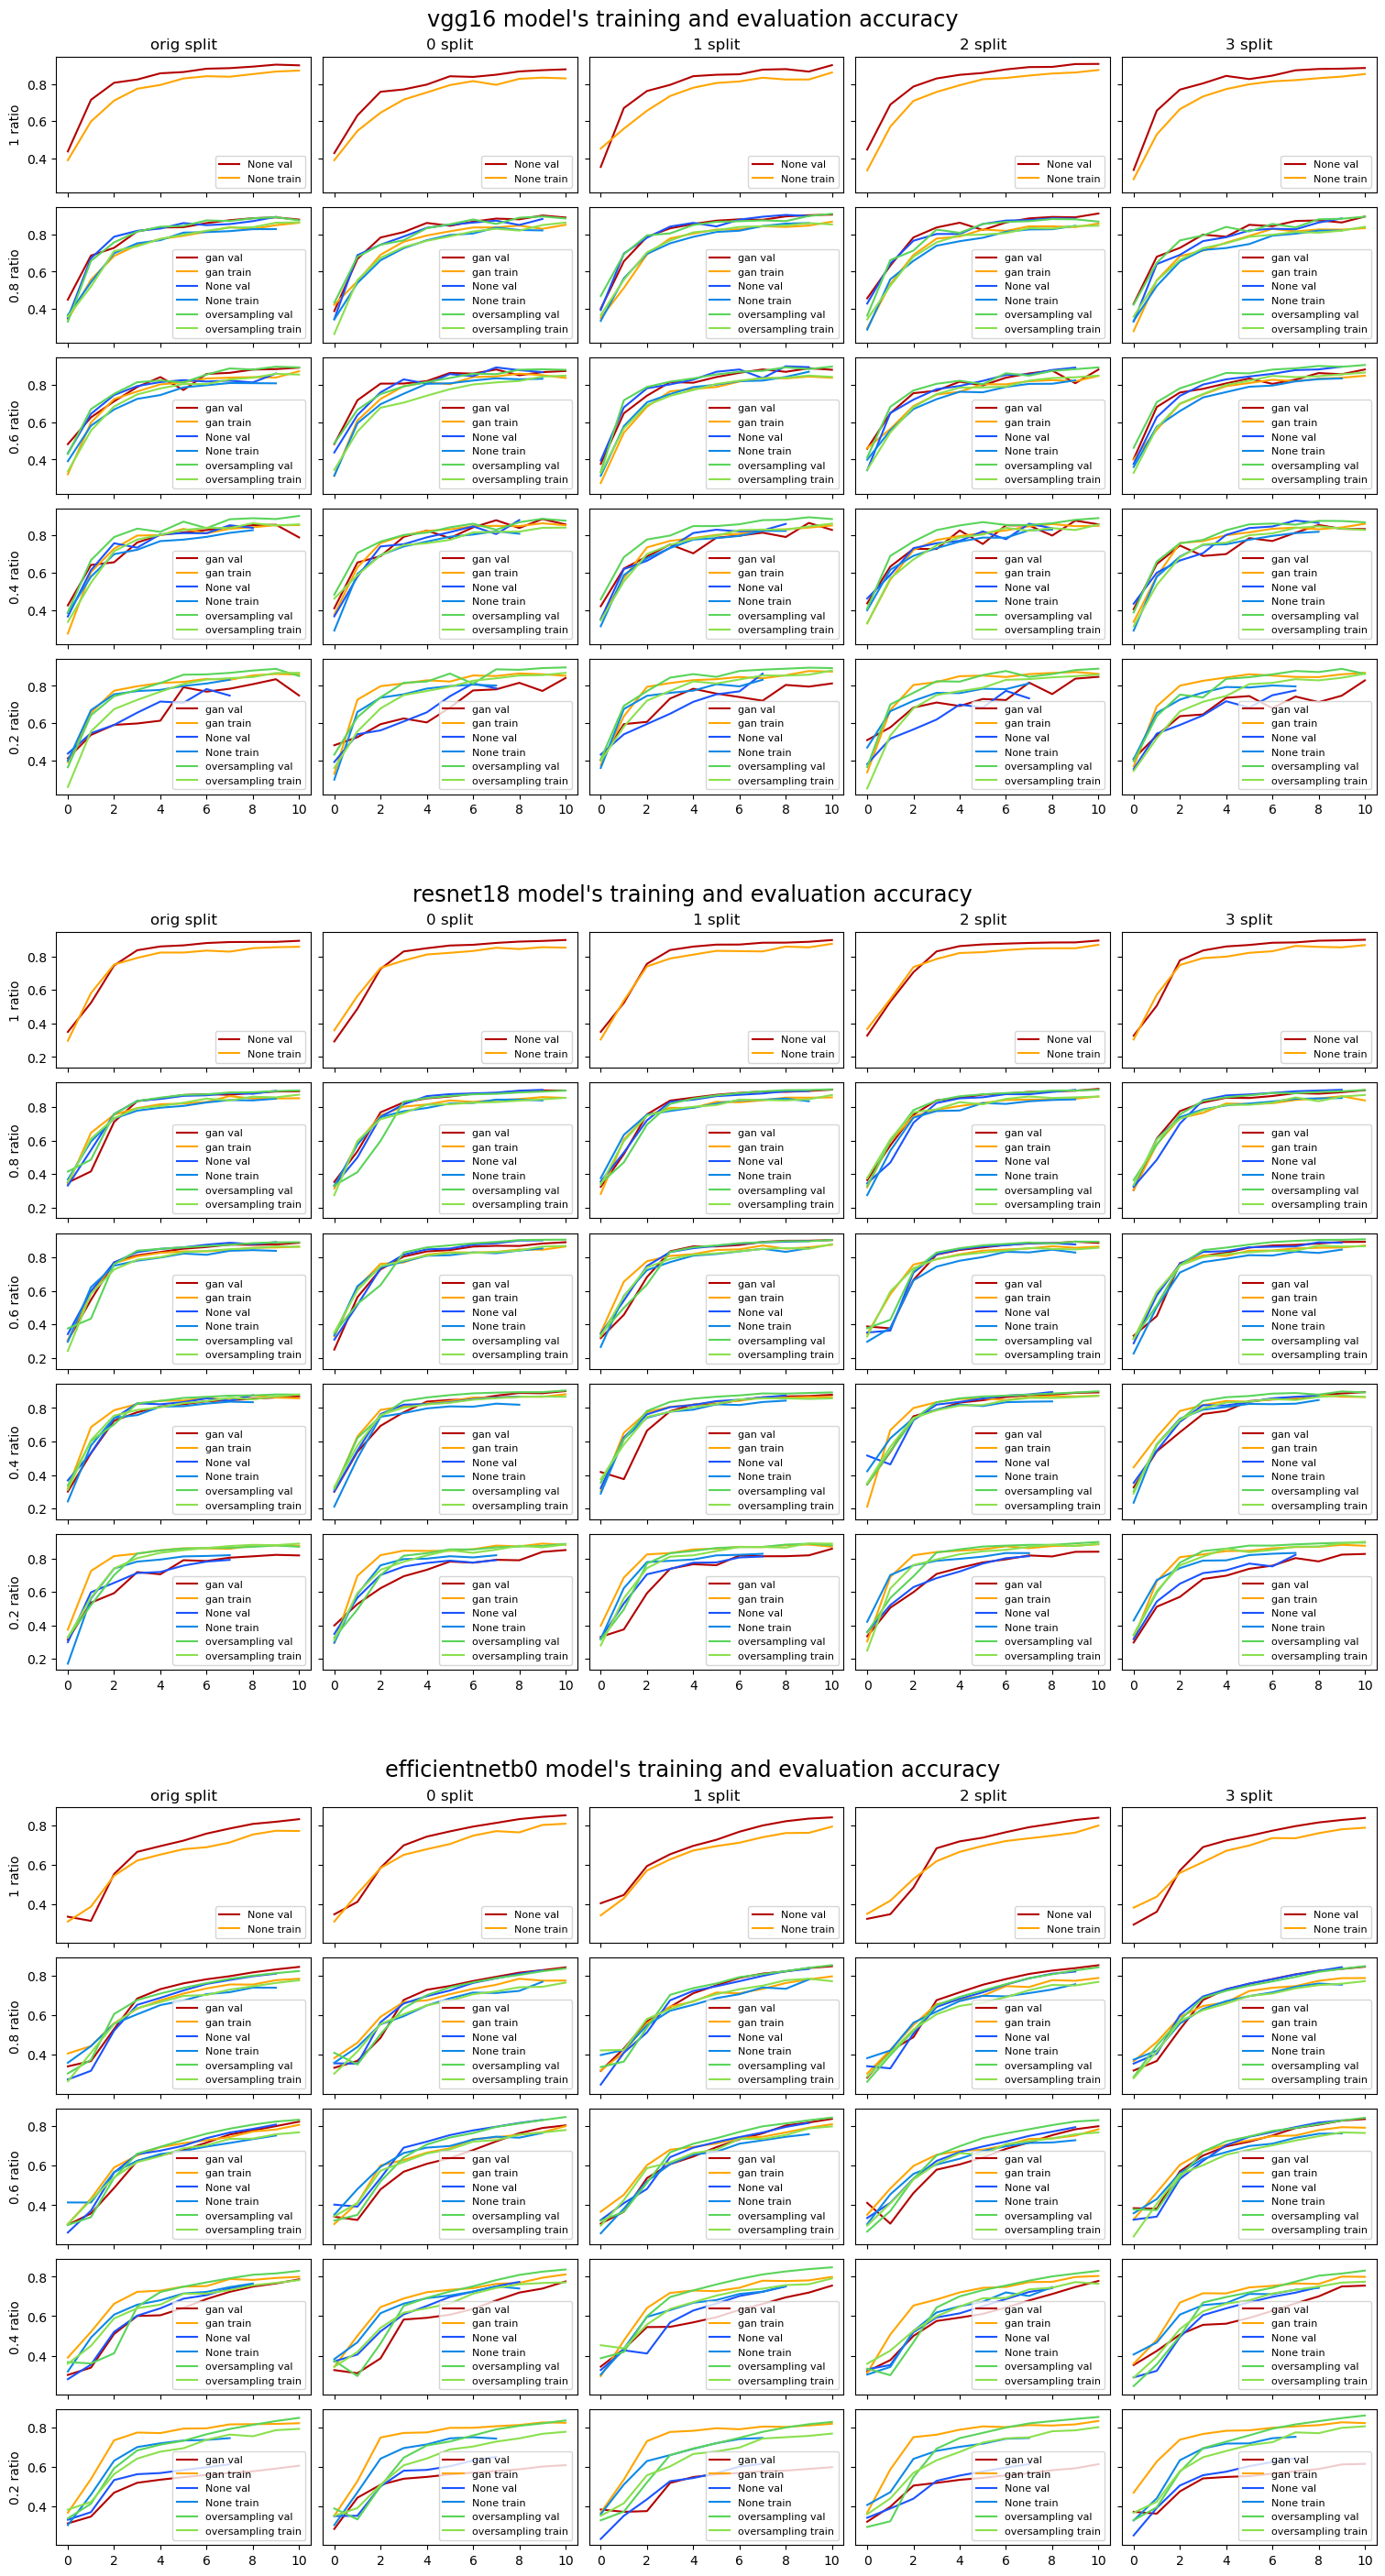

In [28]:
filters()